# MSDS 7337 Final Project - Topic Modeling

Author: Nathan Wall

Date: 8/13/2019

This notebook contains the code and visualizations for the topic modeling of sample of reviews from IMDB from the crime genre

Notebook Sections:
- [Data Preperation](#prep)
- [Topic Modeling](#topicModel)
- [Interpreting Results](#results)

In [22]:
import random 
random.seed(13)
import re
import json
import pandas as pd
import numpy as np

#text pre-processing
import spacy
!python -m spacy download en_core_web_sm

#topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF

#visualizing results
import pyLDAvis.sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#hide depreciation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


## Preparing the reviews
<a id='prep'></a>

Open & read the text file

In [2]:
with open('msds7337_nwall_reviews.json', 'r') as json_file:
    data = json.load(json_file)

reviews = json.loads(data)
len(reviews)

1219

Generate the corpus from the reviews

In [3]:
corpus = [r['reviewText'] for r in reviews]
len(corpus)

1219

Before generating document word matrix let's apply some pre-processing to our data. Below we utilize spacy pre-processing pipeline to tokenize our reviews, but also apply some POS tagging & Named entity recognition to give us more flexibility in how we want to look at our data. Below is an example for a single review.

In [4]:
corpus[1]

"A nice easy breezy murder mystery. Full of fun. Don't count on anything serious or deep here just sit back with your popcorn and a soda and enjoy the movie. Nothing offencive here. Just an adult murder mystery romp. We don't get many like these anymore. Ignore the people who like to criticize everything because they think they are actual critics. Chemistry between Aniston and Sadler is awesome. I hope they make more movies together."

No lets remove all the stop words, punctuation, pronouns, & named entities to get a much more generalized review. To do this we created our own function to apply to a single text.

In [5]:
#load default pipeline
nlp = spacy.load("en_core_web_sm")

def preprocess_review(text, remove_ne = True):
    """ This function takes a document and applies some of preprocessing step

    :param text: A string, the single document you want to process.
    :param remove_ne: A boolean , whether you remove named entities from the text
    
    returns: A string with all tokens lemmatized & lower case with stop words, pronouns, and punctuation removed
    """
    doc = nlp(text)
    if remove_ne == True:
        named_entity = [i.text for i in doc.ents] #create list of named entities
        tokens = [token.lemma_.lower() for token in doc #take the lower case lemmatized word
                  if token.lemma_ != "-PRON-" #remove pronouns
                  and token.lemma_ != "." #remove punction
                  and token.is_stop == False #remove stopwords
                  and token.text not in named_entity #remove named entities
                 ]
    else:
        tokens = [token.lemma_.lower() for token in doc #take the lower case lemmatized word
                  if token.lemma_ != "-PRON-" #remove pronouns
                  and token.lemma_ != "." #remove punction
                  and token.is_stop == False #remove stopwords
                 ]

    tokens = " ".join(tokens)
    return tokens

tokens = preprocess_review(corpus[1])
print(tokens)

nice easy breezy murder mystery fun count deep sit popcorn soda enjoy movie offencive adult murder mystery romp like anymore ignore people like criticize think actual critic chemistry awesome hope movie


The resulting review and is now much more normalized and hopefully our topic models will not be as biased by mention or specific entities or high frequency stop words. We continue on by applying this function to all the texts and creating a sparse TF-IDF object to used for LDA.

In [6]:
processed_corpus = [preprocess_review(doc) for doc in corpus]
print(len(processed_corpus))
print(processed_corpus[1])

1219
nice easy breezy murder mystery fun count deep sit popcorn soda enjoy movie offencive adult murder mystery romp like anymore ignore people like criticize think actual critic chemistry awesome hope movie


In [15]:
#use the TfidfVectorizer 
#first pass with default had some issues so re-running with some cutoffs
vectorizer = TfidfVectorizer(min_df=3, max_df=0.90)
tf_idf = vectorizer.fit_transform(processed_corpus)
tf_idf.shape

(1219, 3166)

## Topic Modeling on Reviews
<a id='topicModel'></a>

For our topic modeling we suspect that NMF (Non-negative Matrix Factorization) will perform better than LDA (Latent Dirichlet Allocation) for this task. This is largely based on the information provided in as part of the Unit 13 asyncronous material. In the material NMF was described as method that woks better on smaller corpuses with shorter documents. While LDA requires a very large number of documents to acheive a good topic model.

Considering we only have 1219 documents in our corpus and the review length while variable is much smaller than the ideal document length for LDA. Let's test out both the fits and determine if we can validate the hypothesis that NMF is a better method for this data.

In [16]:
#function for printing each topics top words 
#source: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [17]:
n_components = 10
n_top_words = 10

##### Fit the NMF

In [18]:
nmf = NMF(n_components=n_components).fit(tf_idf)

print("\nTopics in Default NMF model")
tfidf_feature_names = vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in Default NMF model
Topic #0: character like story time way episode show life think crime
Topic #1: movie action wick john time scene like amazing entertain reeves
Topic #2: season wait episode brilliant writer start leave stop want go
Topic #3: good tv see television show cast hope absolutely new actor
Topic #4: watch episode people worth time not hate find guess amazing
Topic #5: great actor story start character potential acting writing cast fantastic
Topic #6: bad breaking break acting saul well think goodman simply believe
Topic #7: series book episode read drama brilliant year wait novel tv
Topic #8: love episode funny amazing laugh week kind see thank actor
Topic #9: film action man john old point wick comedy bank feel



##### Fitting the LDA

In [19]:
lda = LDA(n_components=n_components).fit(tf_idf)

print("\nTopics in Default LDA model")
tfidf_feature_names = vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)


Topics in Default LDA model
Topic #0: awful fake oh dramatic mess painful dear b99 gem praise
Topic #1: flaw bs engaging crazy great making ted rave zac fortune
Topic #2: good season watch character like series episode great movie time
Topic #3: expect grip adam sandler it meaningless heist unpredictable unfunny vulgar
Topic #4: martial 100 torture elizabeth excellent goodbye indulgent inconsistent total dollar
Topic #5: promise com overrated http bacon www start confusing well supernatural
Topic #6: katic loud stana suspenseful fox drivel cancel decline substance recommend
Topic #7: worth brilliant big jones christie agatha superhero disappointing jessica wolf
Topic #8: downhill happen twisted flawed run portrayal endeavour teenager sitcom turn
Topic #9: spoiler robber robbery bank rob sissy forrest spiral redford stumble



Upon initial look a few things pop out:

1) The NMF topics seem much more high level and it seems like there is some seperation between the topics, with some topics appearing better than other. While the LDA model is driven by very specific terms that are likely much less common, making it difficult to interpret. Perhaps increasing the cut-off for the words considered would help this out.

2) The preprocessing failed to remove all of the Named Entity mainly awhen it comes to specific character names, i.e. John Wick. 

We will visulize the models to explore how these models performed better in our next step.

## Visualizing Results
<a id='results'></a>

In [30]:
### Function for visualizing topics using t-SNE
def topic_map(vectorized_corpus, model):
    """ This function using a topic model & vectorized corpus create a plot for interpreting results

    :param vectorized_corpus: A sparse matrix, the vectorization of a corpus using sklearn vectorizers.
    :param model: A sklearn model object , a fitted topic mode for the vectorized data
    
    returns: A plot of all documents colored by topic based on their t-SNE values
    """
    
    #embed corpus as topic model
    model_embedding = model.transform(vectorized_corpus)
    model_embedding = (model_embedding - model_embedding.mean(axis=0))/model_embedding.std(axis=0)

    #apply tsne dimensionality reduction for plotting
    tsne = TSNE(random_state=3211)
    tsne_embedding = tsne.fit_transform(model_embedding)
    tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
    tsne_embedding['hue'] = model_embedding.argmax(axis=1)

    #plot topics based on tsne reductions
    fig, axs = plt.subplots(figsize=(10, 10), facecolor='w', edgecolor='k')
    scatter = axs.scatter(data=tsne_embedding, x='x', y='y', c=tsne_embedding['hue']) 
    

##### Visualizing NMF

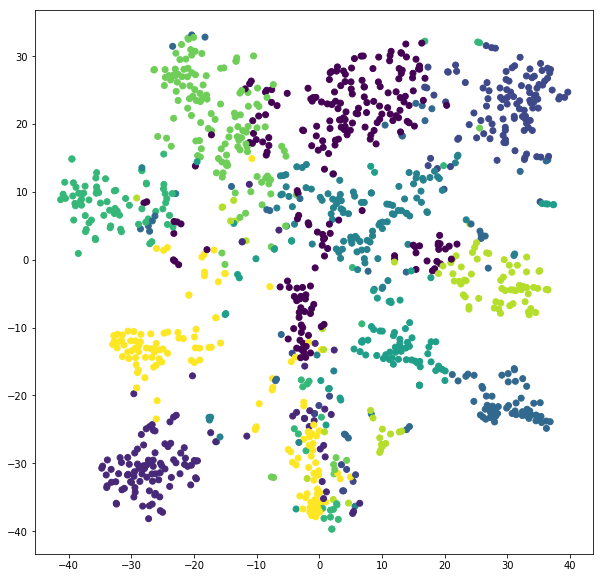

In [31]:
topic_map(tf_idf, nmf)

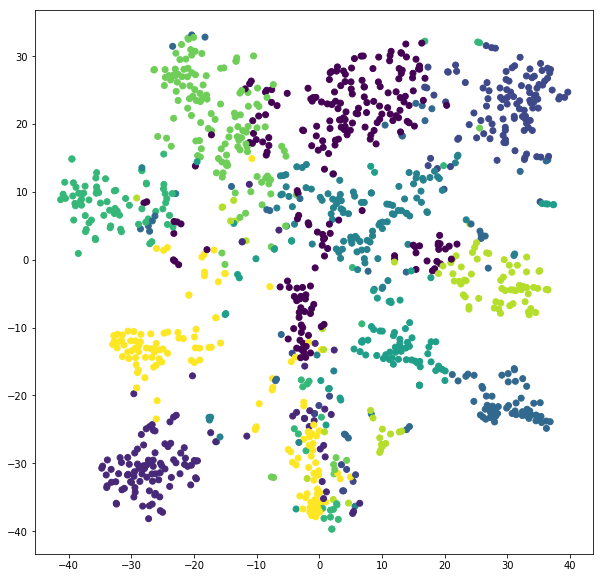

In [27]:
model_embedding = model.transform(vectorized_corpus)
model_embedding = (model_embedding - model_embedding.mean(axis=0))/model_embedding.std(axis=0)


tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(model_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = model_embedding.argmax(axis=1)

fig, axs = plt.subplots(figsize=(10, 10), facecolor='w', edgecolor='k')
scatter = axs.scatter(data=tsne_embedding, x='x', y='y', c=tsne_embedding['hue'])

##### Visualizing LDA

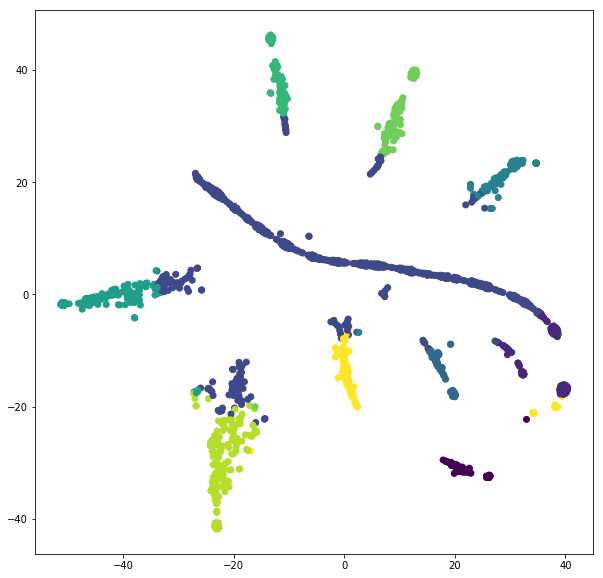

In [28]:
lda_embedding = lda.transform(tf_idf)
lda_embedding = (lda_embedding - lda_embedding.mean(axis=0))/lda_embedding.std(axis=0)


tsne = TSNE(random_state=3211)
tsne_embedding_lda = tsne.fit_transform(lda_embedding)
tsne_embedding_lda = pd.DataFrame(tsne_embedding_lda,columns=['x','y'])
tsne_embedding_lda['hue'] = lda_embedding.argmax(axis=1)

fig, axs = plt.subplots(figsize=(10, 10), facecolor='w', edgecolor='k')
scatter = axs.scatter(data=tsne_embedding_lda, x='x', y='y', c=tsne_embedding_lda['hue'])

In [21]:
pyLDAvis.enable_notebook()
ldaVis = pyLDAvis.sklearn.prepare(lda, tf_idf, vectorizer, mds='tsne')
pyLDAvis.display(ldaVis)

/home/newall/anaconda3/envs/nlp/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
